In [4]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
from graphviz import Digraph
from IPython.display import display, Image
import os
import math
from wand.image import Image
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import requests

import warnings
warnings.filterwarnings('ignore')

### 1 读取调用链和fault

In [2]:
fault = pd.read_excel('/Users/wangxue/gitpro/20200307AIOps/官方AIOps挑战赛数据/故障整理all.xlsx')
fault['start_time'] = pd.to_datetime(fault['start_time']) #标准数据
fault.head(1)

,index,object,fault_desrcibtion,kpi,name,start_time,log_time,log_block,block,duration
0,1,docker,CPU fault,container_cpu_used,docker_003,2020-04-11 00:05:00,2020-04-11 00:05:00,NaN,NaN,5min


In [38]:
path_date = '2020_05_29'

In [39]:
# path = '/Users/wangxue/Desktop/AIOps挑战赛/data_release_v2.0_20200411/调用链指标/'
path = '/Users/wangxue/gitpro/20200307AIOps/官方AIOps挑战赛数据/AIOps挑战赛数据/' + path_date + '/调用链指标/'

# 读取调用链
trace_csf = pd.read_csv(path + 'trace_csf.csv')
trace_fly_remote = pd.read_csv(path +'trace_fly_remote.csv')
trace_jdbc = pd.read_csv(path + 'trace_jdbc.csv')
trace_local = pd.read_csv(path + 'trace_local.csv')
trace_osb = pd.read_csv(path +'trace_osb.csv')
trace_remote_process = pd.read_csv(path + 'trace_remote_process.csv')

# concat all
all_trace = pd.concat([trace_csf, trace_fly_remote, trace_jdbc, \
                   trace_local, trace_osb, trace_remote_process], axis=0, sort=False)
all_trace.reset_index(drop=True, inplace=True)

# time format
all_trace["startTime"] = \
all_trace["startTime"].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000)\
                                   .strftime('%Y-%m-%d %H:%M:%S'))
all_trace["startTime"] = pd.to_datetime(all_trace["startTime"])

In [40]:
all_trace.head(1)

,callType,startTime,elapsedTime,success,traceId,id,pid,cmdb_id,serviceName,dsName
0,CSF,2020-05-29,842.0,True,40271440bb8711024e67,40271ac2e53811034e67,402718cc779711024e67,os_021,csf_001,NaN


In [41]:
esb = pd.read_csv('/Users/wangxue/gitpro/20200307AIOps/官方AIOps挑战赛数据/AIOps挑战赛数据/' +path_date+ '/业务指标/esb.csv')

esb['startTime'] = esb["startTime"].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000)\
                                   .strftime('%Y-%m-%d %H:%M:%S'))
esb["startTime"] = pd.to_datetime(esb["startTime"])

In [42]:
esb.head(5)

,serviceName,startTime,avg_time,num,succee_num,succee_rate
0,osb_001,2020-05-29 00:00:00,0.7525,350,350,1.0
1,osb_001,2020-05-29 00:01:00,0.6607,334,334,1.0
2,osb_001,2020-05-29 00:02:00,0.6373,332,332,1.0
3,osb_001,2020-05-29 00:03:00,0.6579,365,365,1.0
4,osb_001,2020-05-29 00:04:00,0.6176,392,392,1.0


In [43]:
# 需要遍历每天来加载trace数据

In [44]:
fault_date = fault.loc[(fault['start_time'] < pd.datetime(2020,
                                                          int(path_date.split('_')[1]),
                                                          int(path_date.split('_')[2]),
                                                          23,59,59)) &
                        (fault['start_time'] > pd.datetime(2020,
                                                           int(path_date.split('_')[1]),
                                                           int(path_date.split('_')[2]),0,0,0)),:]

### 2 构造ESB特征数据

In [45]:
# 根据esb指标来构建序列的mean特征, 故障时间的后later_minite内的统计特征
# mode 是 1 mean，2 max，3 min
def esb_feature_intofault(later_minite, feature_name, mode):
    for index, row in fault_date.iterrows():
        start_time = fault_date.at[index,'start_time']
        duration = pd.Timedelta(days=0, minutes=later_minite, seconds=0)
        if(mode == 1):
            esb_avg_time = esb.loc[(esb['startTime'] < start_time + duration) & 
                                   (esb['startTime'] >= start_time),:][feature_name].mean()
            fault_date.at[index, 'esb_'+str(later_minite)+'_'+feature_name+'_mean'] = esb_avg_time
        elif(mode == 2):
            esb_avg_time = esb.loc[(esb['startTime'] < start_time + duration) & 
                                   (esb['startTime'] >= start_time),:][feature_name].max()
            fault_date.at[index, 'esb_'+str(later_minite)+'_'+feature_name+'_max'] = esb_avg_time
        elif(mode == 3):
            esb_avg_time = esb.loc[(esb['startTime'] < start_time + duration) & 
                                   (esb['startTime'] >= start_time),:][feature_name].min()
            fault_date.at[index, 'esb_'+str(later_minite)+'_'+feature_name+'_min'] = esb_avg_time   
        else:
            print("mode wrong!")

In [46]:
later_minites = [2,5]
feature_names = ['avg_time','num','succee_num','succee_rate']
for mini in later_minites:
    for fea in feature_names:
        esb_feature_intofault(mini, fea, 1)

In [47]:
fault_date.head()

,index,object,fault_desrcibtion,kpi,name,start_time,log_time,log_block,block,duration,esb_2_avg_time_mean,esb_2_num_mean,esb_2_succee_num_mean,esb_2_succee_rate_mean,esb_5_avg_time_mean,esb_5_num_mean,esb_5_succee_num_mean,esb_5_succee_rate_mean
101,148,db,db connection limit,Proc_User_Used_Pct;Proc_Used_Pct;Sess_Connect,db_003,2020-05-29 02:11:00,2020-05-12 02:11:00,8.0,8.0,5min,7.360733,260.000000,255.000000,0.9848,6.597963,259.375000,257.500000,0.9943
102,149,docker,CPU fault,container_cpu_used,docker_008,2020-05-29 02:41:00,2020-05-12 02:41:00,8.0,8.0,5min,1.564200,377.500000,377.500000,1.0000,3.789229,203.571429,203.571429,1.0000
103,150,docker,CPU fault,container_cpu_used,docker_001,2020-05-29 03:41:00,2020-05-12 03:41:00,8.0,8.0,5min,9.937200,125.666667,125.666667,1.0000,11.513737,85.500000,85.500000,1.0000
104,151,docker,network delay,NaN,docker_006,2020-05-29 05:11:00,2020-05-12 05:11:00,8.0,8.0,5min,12.618700,122.000000,122.000000,1.0000,14.178200,67.875000,67.875000,1.0000


### 3.2 构造trace调用时序特征

In [48]:
cmdb_names = ['docker_001','docker_002','docker_003','docker_004',
              'docker_005', 'docker_006', 'docker_007','docker_008', 
             'db_003','db_007','db_009',
             'os_001','os_002','os_003','os_004','os_005','os_006','os_007','os_008','os_009','os_010','os_011',
             'os_012','os_013','os_014','os_015','os_016','os_017','os_018','os_019','os_020','os_021','os_022']
# 拼接所有的fault的 trace 时序 特征
for cmdb_pid in cmdb_names:
    for cmdb_id in cmdb_names:
        fault_date.insert(fault_date.shape[1], cmdb_pid+'_'+cmdb_id, 0.0)

In [49]:
fault_date.index.to_list()

[101, 102, 103, 104]

####  3.2.1 一次异常分数矩阵的计算

In [253]:
# 参数minutes
anomaly_id = fault_date.index.to_list()[4]  # fault csv的index
start_time = fault_date.at[anomaly_id,'start_time']
print(anomaly_id, start_time)

duration = pd.Timedelta(days=0, minutes=2, seconds=0)

all_trace_duration = all_trace.loc[ (all_trace['startTime'] > start_time - duration) &
                                   (all_trace['startTime'] <= start_time + duration), : ]

57 2020-05-22 02:18:00


In [254]:
#all_trace_duration.shape

In [255]:
#对all_trace_duration的前 n_chain 个调用链， 去除子调用们的耗时，得到真实耗时
traceIds = all_trace_duration['traceId'].value_counts().to_frame()
traceId_num = 120
top_traceIds = traceIds.head(traceId_num).index

# 先只对 top_traceIds 的调用链做处理： ！！！
all_trace_duration_top_traceIds = all_trace_duration.loc[all_trace_duration['traceId'].isin(top_traceIds.to_list())]

In [256]:
for traceId in top_traceIds:
    # 同一个traceid的一次整体全部调用
    oneCall = all_trace_duration_top_traceIds.loc[all_trace_duration_top_traceIds['traceId'] == traceId]
    for unq_id in oneCall['id'].unique():
        unq_id_child_elapsedTime = 0
        try:
            unq_id_child_elapsedTime = oneCall[oneCall['pid'] == unq_id]['elapsedTime'].sum()
        except:
            print("unq_id_child_elapsedTime 0")
        
        # 从oneCall获取index，这样从 all_trace_duration里取值更快
        unq_id_index = oneCall.loc[oneCall['id'] == unq_id].index.tolist()[0]
#         print('before: ', unq_id,
#               all_trace_duration_top_traceIds.at[unq_id_index, 'elapsedTime'])
        
        all_trace_duration_top_traceIds.at[unq_id_index, 'elapsedTime'] -= unq_id_child_elapsedTime
#         print('after: ', all_trace_duration_top_traceIds.at[unq_id_index, 'id'] ,
#               all_trace_duration_top_traceIds.at[unq_id_index, 'elapsedTime'])

In [257]:
all_trace_duration_top_traceIds.insert(all_trace_duration.shape[1], 'newServiceName', np.NAN)

all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'JDBC'),'newServiceName'] = \
all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'JDBC'),'dsName']

all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'LOCAL'),'newServiceName'] = \
all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'LOCAL'),'dsName']

all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'RemoteProcess'),'newServiceName'] = \
all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'RemoteProcess'),'cmdb_id']

In [258]:
def fill_newServiceName(id_para, col):
    try: 
        return all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.pid == id_para), col].values[0]
    except:
        return np.NAN

In [259]:
# 对于CSF类的需要结合子调用，使用子调用的cmbdid作为本次调用的serviceName， all_trace_duration_top_traceIds少快点
all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'CSF'),'newServiceName'] = \
all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'CSF'),:].apply(lambda row: fill_newServiceName(row['id'], 'cmdb_id'), axis = 1)

In [260]:
all_trace_duration_top_traceIds.tail()

,callType,startTime,elapsedTime,success,traceId,id,pid,cmdb_id,serviceName,dsName,newServiceName
8393226,RemoteProcess,2020-05-22 02:20:00,28.0,True,41271f22d966837762a6,41271d77c575920862a6,41271f043996830862a6,docker_003,csf_001,NaN,docker_003
8393231,RemoteProcess,2020-05-22 02:20:00,27.0,True,41271f22d966837762a6,41271fc6bb0737f862a6,41271c313b1792c862a6,docker_007,csf_002,NaN,docker_007
8393237,RemoteProcess,2020-05-22 02:20:00,14.0,True,41271f22d966837762a6,41271977f15247bb62a6,412718310d97928b62a6,docker_007,csf_003,NaN,docker_007
8393241,RemoteProcess,2020-05-22 02:20:00,10.0,True,41271f22d966837762a6,41271adb569487cd62a6,4127162e8b58929d62a6,docker_008,csf_004,NaN,docker_008
8393246,RemoteProcess,2020-05-22 02:20:00,10.0,True,41271f22d966837762a6,41271bc69a48877f62a6,412710d71098922f62a6,docker_008,csf_005,NaN,docker_008


In [261]:
# 双层遍历1： cmdb_id	serviceName	dsName 的时序图看看情况
# pid_col_name =  'pid_cmdb_id' #'pid_newServiceName' 
# id_col_name =  'cmdb_id' #'newServiceName'

pid_col_name =  'cmdb_id' 
id_col_name =  'newServiceName'

interval_point = 10

# 每行是pid， 列对应这 id，被调用的
pid_cmdb_names = all_trace_duration_top_traceIds[pid_col_name].unique()
id_cmdb_names = all_trace_duration_top_traceIds[id_col_name].unique()

df_scores = pd.DataFrame(index = pd.Index(pid_cmdb_names.tolist()), 
                         columns = pd.Index(id_cmdb_names.tolist()))

for pid_cmdb in pid_cmdb_names:
    for id_cmdb in id_cmdb_names:

        # 取出 col_name 里面取值为 cmdb 的调用
        all_trace_duration_top_traceIds_cmdb = \
        all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds[pid_col_name] == pid_cmdb) & \
                                            (all_trace_duration_top_traceIds[id_col_name] == id_cmdb)]
        
        if(all_trace_duration_top_traceIds_cmdb.shape[0] < 2 * interval_point):
            continue;   
        
        # 按时间排序
        all_trace_duration_top_traceIds_cmdb.sort_values(by=['startTime'],ascending=True,inplace=True)

        # anomaly score calculate
        cmdb_avg_ElaTime = all_trace_duration_top_traceIds_cmdb.groupby('startTime')['elapsedTime'].mean().to_frame()
        series_beforeFalut = cmdb_avg_ElaTime.loc[cmdb_avg_ElaTime.index < start_time]['elapsedTime'].tail(interval_point).values
        series_afterFalut = cmdb_avg_ElaTime.loc[cmdb_avg_ElaTime.index >= start_time]['elapsedTime'].head(interval_point).values

        anomaly_score = (series_afterFalut.mean() - series_beforeFalut.mean()) / series_beforeFalut.mean()
        df_scores.loc[pid_cmdb, id_cmdb] = anomaly_score
        
        # 行是index，即anomaly_id； 列是cmdb_pid+'_'+cmdb_id
        fault_date.at[anomaly_id, pid_cmdb+'_'+id_cmdb] = anomaly_score

df_scores

,docker_004,docker_008,docker_007,docker_003,docker_002,docker_006,docker_005,docker_001,NaN,db_003,db_009,db_007
os_021,0.195,NaN,NaN,-0.402788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
docker_004,-0.422507,-0.606539,-0.569177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.803501,-0.705432
docker_003,NaN,-0.654036,-0.573985,-0.541822,NaN,NaN,NaN,NaN,NaN,NaN,0.0162229,-0.548212
os_022,NaN,NaN,NaN,NaN,10.5125,NaN,NaN,1.19278,NaN,NaN,NaN,NaN
docker_002,NaN,NaN,NaN,NaN,0.277485,0.152546,0.308974,NaN,NaN,NaN,1.84951,1.48621
docker_001,NaN,NaN,NaN,NaN,NaN,0.184818,0.0865806,-0.503099,NaN,NaN,0.503945,-0.0404444
docker_008,NaN,-0.0833461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0420202,NaN,NaN
docker_007,NaN,NaN,0.0357541,NaN,NaN,NaN,NaN,NaN,NaN,-0.0606481,NaN,NaN
docker_006,NaN,NaN,NaN,NaN,NaN,0.0853123,NaN,NaN,NaN,-0.0667278,NaN,NaN
docker_005,NaN,NaN,NaN,NaN,NaN,NaN,0.0531595,NaN,NaN,-0.0981394,NaN,NaN


In [262]:
fault_date.at[anomaly_id, 'docker_001_docker_005']

0.08658064516129006

### 3.3 对所有故障 构造trace调用链时序特征 (3.2.1 与 下面代码功能类似，下面只是多了循环)

In [50]:
# !!! 需要遍历 每个故障 fault_date.index.to_list()， 参数minutes
for anomaly_id in fault_date.index.to_list():  # fault csv的index
    start_time = fault_date.at[anomaly_id,'start_time']
    print(anomaly_id, start_time)

    duration = pd.Timedelta(days=0, minutes=2, seconds=0)
    all_trace_duration = all_trace.loc[ (all_trace['startTime'] > start_time - duration) &
                                       (all_trace['startTime'] <= start_time + duration), : ]
    
    #对all_trace_duration的前 traceId_num 个调用链， 去除子调用们的耗时，得到真实耗时
    traceIds = all_trace_duration['traceId'].value_counts().to_frame()
    traceId_num = 120
    top_traceIds = traceIds.head(traceId_num).index
    all_trace_duration_top_traceIds = all_trace_duration.loc[all_trace_duration['traceId'].isin(top_traceIds.to_list())]
    
    for traceId in top_traceIds:
        # 同一个traceid的一次整体全部调用
        oneCall = all_trace_duration_top_traceIds.loc[all_trace_duration_top_traceIds['traceId'] == traceId]
        for unq_id in oneCall['id'].unique():
            unq_id_child_elapsedTime = 0
            try:
                unq_id_child_elapsedTime = oneCall[oneCall['pid'] == unq_id]['elapsedTime'].sum()
            except:
                print("unq_id_child_elapsedTime 0")

            # 从oneCall获取index，这样从 all_trace_duration里取值更快
            unq_id_index = oneCall.loc[oneCall['id'] == unq_id].index.tolist()[0]
            all_trace_duration_top_traceIds.at[unq_id_index, 'elapsedTime'] -= unq_id_child_elapsedTime  
    
    
    # 服务网元预处理
    def fill_newServiceName(id_para, col):
        try: 
            return all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.pid == id_para), col].values[0]
        except:
            return np.NAN
    all_trace_duration_top_traceIds.insert(all_trace_duration.shape[1], 'newServiceName', np.NAN)
    all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'JDBC'),'newServiceName'] = \
    all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'JDBC'),'dsName']

    all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'LOCAL'),'newServiceName'] = \
    all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'LOCAL'),'dsName']

    all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'RemoteProcess'),'newServiceName'] = \
    all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'RemoteProcess'),'cmdb_id']
    
    # 对于CSF类的需要结合子调用，使用子调用的cmbdid作为本次调用的serviceName， all_trace_duration_top_traceIds少快点
    all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'CSF'),'newServiceName'] = \
    all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds.callType == 'CSF'),:].apply(lambda row: fill_newServiceName(row['id'], 'cmdb_id'), 
                                                                                                     axis = 1)
    # 网元间的异常分数矩阵 计算
    pid_col_name =  'cmdb_id' 
    id_col_name =  'newServiceName'
    interval_point = 5

    # 每行是pid， 列对应这 id，被调用的
    pid_cmdb_names = all_trace_duration_top_traceIds[pid_col_name].unique()
    id_cmdb_names = all_trace_duration_top_traceIds[id_col_name].unique()

    df_scores = pd.DataFrame(index = pd.Index(pid_cmdb_names.tolist()), columns = pd.Index(id_cmdb_names.tolist()))

    for pid_cmdb in pid_cmdb_names:
        for id_cmdb in id_cmdb_names:

            # 取出 col_name 里面取值为 cmdb 的调用
            all_trace_duration_top_traceIds_cmdb = \
            all_trace_duration_top_traceIds.loc[(all_trace_duration_top_traceIds[pid_col_name] == pid_cmdb) & \
                                                (all_trace_duration_top_traceIds[id_col_name] == id_cmdb)]

            if(all_trace_duration_top_traceIds_cmdb.shape[0] < 2 * interval_point):
                continue;   

            # 按时间排序
            all_trace_duration_top_traceIds_cmdb.sort_values(by=['startTime'],ascending=True,inplace=True)

            # anomaly score calculate
            cmdb_avg_ElaTime = all_trace_duration_top_traceIds_cmdb.groupby('startTime')['elapsedTime'].mean().to_frame()
            series_beforeFalut = cmdb_avg_ElaTime.loc[cmdb_avg_ElaTime.index < start_time]['elapsedTime'].tail(interval_point).values
            series_afterFalut = cmdb_avg_ElaTime.loc[cmdb_avg_ElaTime.index >= start_time]['elapsedTime'].head(interval_point).values

            anomaly_score = (series_afterFalut.mean() - series_beforeFalut.mean()) / series_beforeFalut.mean()
            df_scores.loc[pid_cmdb, id_cmdb] = anomaly_score
            
            # 行是index，即anomaly_id； 列是cmdb_pid+'_'+cmdb_id
            fault_date.at[anomaly_id, pid_cmdb+'_'+id_cmdb] = anomaly_score 

101 2020-05-29 02:11:00
102 2020-05-29 02:41:00
103 2020-05-29 03:41:00
104 2020-05-29 05:11:00


In [51]:
fault_date[['docker_002_docker_002','os_022_docker_002']]

,docker_002_docker_002,os_022_docker_002
101,2.479853,15.339831
102,2.230769,6.015829
103,-0.458564,2.815447
104,0.285374,-0.700884


In [52]:
df_scores

,docker_003,docker_006,docker_004,docker_002,docker_008,docker_007,docker_001,NaN,db_003,db_009,db_007
os_021,-0.490997,NaN,6.40073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
docker_003,1.6546,4.47256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.27317,3.95726
docker_004,NaN,3.19406,0.598673,NaN,NaN,NaN,NaN,NaN,NaN,3.71106,5.14634
os_022,NaN,NaN,NaN,-0.700884,NaN,NaN,-0.0749717,NaN,NaN,NaN,NaN
docker_002,NaN,NaN,NaN,0.285374,7.625,1.38627,NaN,NaN,NaN,1.81456,0.047619
docker_001,NaN,NaN,NaN,NaN,3.35115,4.70281,1.18024,NaN,NaN,4.25899,9.09722
docker_006,NaN,0.332248,NaN,NaN,NaN,NaN,NaN,NaN,0.0492812,NaN,NaN
docker_008,NaN,NaN,NaN,NaN,0.028129,NaN,NaN,NaN,-0.0952218,NaN,NaN
docker_007,NaN,NaN,NaN,NaN,NaN,0.06092,NaN,NaN,0.0605209,NaN,NaN


In [53]:
fault_date.shape

(4, 1107)

In [66]:
#fault_date.to_csv('../faults/fault_' +path_date+ '.csv', index=0)

### 4 trace里false的调用数量特征

In [54]:
fault_date.insert(fault_date.shape[1], 'trace_success_rate_2min', np.NAN)

In [55]:
for anomaly_id in fault_date.index.to_list():  # fault csv的index
    start_time = fault_date.at[anomaly_id,'start_time']
    print(anomaly_id, start_time)

    duration = pd.Timedelta(days=0, minutes=2, seconds=0)
    all_trace_duration = all_trace.loc[ (all_trace['startTime'] > start_time ) &
                                           (all_trace['startTime'] <= start_time + duration), : ]
    
    try:
        fault_date.at[anomaly_id, 'trace_success_rate_2min'] = all_trace_duration['success'].value_counts().to_dict()[False] / all_trace_duration.shape[0]
    except:
        fault_date.at[anomaly_id, 'trace_success_rate_2min'] = 0.0

101 2020-05-29 02:11:00
102 2020-05-29 02:41:00
103 2020-05-29 03:41:00
104 2020-05-29 05:11:00


In [56]:
fault_date[['index','trace_success_rate_2min']]

,index,trace_success_rate_2min
101,148,0.001345
102,149,0.000000
103,150,0.000000
104,151,0.000000


In [58]:
fault_date.to_csv('../faults/fault_' +path_date+ '.csv', index=0)

### 5 LightGBM 或 随机森林 多分类模型训练

In [1]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,ShuffleSplit,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,make_scorer,precision_score,recall_score,f1_score, confusion_matrix,classification_report
from sklearn.svm import SVC

In [2]:
# faults数据拼接到一起

In [5]:
data_file = '../faults/'
dataset = pd.DataFrame()

for path, dir_list, file_list in os.walk(data_file) :  
    for file_name in file_list:  
        data_path = os.path.join(path, file_name)
        fault_score = pd.read_csv(data_path)
        fault_score = fault_score[fault_score.columns.difference(['object','fault_desrcibtion',
                                                                 'kpi','start_time','log_time','log_block',
                                                                 'block','duration'])]
        fault_score.rename(columns={'name':'label'},inplace=True)
        
        if(dataset.empty):
            dataset = fault_score
        else:
            #concat data rename col
            dataset = pd.concat([dataset, fault_score], ignore_index=True)

In [6]:
# 去掉全NAN的列
dataset.dropna(how='all', axis = 1, inplace=True)
dataset.fillna(0.0, inplace=True)
# 去掉全0的列
dataset = dataset.loc[:,(dataset != 0).any(axis=0)]

In [7]:
dataset.shape

(97, 51)

In [9]:
dataset.to_csv('../dataset.csv')

In [88]:
dataset['label'].value_counts()

docker_001    13
docker_006    10
db_003         8
docker_002     8
docker_004     7
docker_003     7
db_007         6
docker_008     6
os_021         6
os_018         6
docker_007     5
docker_005     4
os_017         4
os_020         4
os_009         2
os_001         1
Name: label, dtype: int64

In [89]:
#Creating the dependent variable class， 多分类
factor = pd.factorize(dataset['label'])
dataset.label = factor[0]
definitions = factor[1]
print(factor)

(array([ 0,  1,  2,  3,  4,  1,  0,  0,  5,  6,  7,  8,  9, 10,  7,  4,  4,
        2,  6,  2, 11,  0,  4,  5, 11,  8, 12, 13,  1,  3,  4,  1,  0, 10,
        3, 12,  9,  7,  7,  2, 14,  8, 14,  6, 10,  3,  7, 11, 15, 10, 11,
       10, 14,  6,  2,  2,  2,  8,  5,  7,  5,  2, 10,  4,  1,  0, 10,  3,
        2,  2,  1,  2,  8, 11, 14, 10,  2, 15, 12,  1,  3,  8,  1, 12,  9,
        7,  6,  2,  5,  5, 11,  9,  7,  3, 10, 10,  0]), Index(['docker_003', 'docker_002', 'docker_001', 'docker_004', 'db_007',
       'docker_008', 'docker_007', 'db_003', 'os_018', 'os_017', 'docker_006',
       'os_021', 'os_020', 'os_001', 'docker_005', 'os_009'],
      dtype='object'))


In [90]:
#Splitting the data into independent and dependent variables
label = dataset.pop('label')
fault_index = dataset.pop('index')

In [91]:
col_names = dataset.columns

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, label, test_size = 0.4, random_state = 21)

In [69]:
# Feature Scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [96]:
# 搜索rfc参数
for es in range(100,800,100):
    for de in range(4,12,2):
        rfc = RandomForestClassifier(n_estimators=es, 
                                     criterion='entropy', 
                                     max_depth=de, 
                                     max_features=5, 
                                     min_samples_split=4, 
                                     oob_score=True)
        rfc.fit(X_train,Y_train) 
        y_pred = rfc.predict(X_test)
        print('es', es, 'de ', de , 'report' ,'\n',
              sklearn.metrics.classification_report(Y_test, y_pred))

es 100 de  4 report 
               precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.00      0.00      0.00         4
           2       0.29      0.80      0.42         5
           3       0.00      0.00      0.00         3
           4       0.12      1.00      0.22         1
           5       0.67      0.67      0.67         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       1.00      0.14      0.25         7
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy                           0.28        39
   m

es 300 de  4 report 
               precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.00      0.00      0.00         4
           2       0.25      0.60      0.35         5
           3       0.25      0.33      0.29         3
           4       0.17      1.00      0.29         1
           5       1.00      1.00      1.00         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       1.00      0.14      0.25         7
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy                           0.31        39
   m

es 500 de  4 report 
               precision    recall  f1-score   support

           0       0.20      0.50      0.29         2
           1       0.00      0.00      0.00         4
           2       0.31      0.80      0.44         5
           3       0.00      0.00      0.00         3
           4       0.14      1.00      0.25         1
           5       0.67      0.67      0.67         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         1
           9       0.50      1.00      0.67         1
          10       1.00      0.14      0.25         7
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy                           0.28        39
   m

es 700 de  4 report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.29      0.80      0.42         5
           3       0.00      0.00      0.00         3
           4       0.14      1.00      0.25         1
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy                           0.21        39
   m

es 900 de  4 report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.25      0.60      0.35         5
           3       0.00      0.00      0.00         3
           4       0.17      1.00      0.29         1
           5       0.67      0.67      0.67         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         1
          10       1.00      0.14      0.25         7
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy                           0.26        39
   m

In [104]:
# model
# model = RandomForestClassifier(n_estimators=40, 
#                              criterion='gini', 
#                              max_depth=5,
#                              max_features=10, 
#                              min_samples_split=10, 
#                              oob_score=True)
#model = SVC(C=2, kernel='rbf')
model = RandomForestClassifier(n_estimators=500, 
                             criterion='entropy', 
                             max_depth=8, 
                             max_features=5, 
                             min_samples_split=4, 
                             oob_score=True)

In [105]:
model.fit(X_train,Y_train) 
y_pred = model.predict(X_test)
matrix = confusion_matrix(Y_test, y_pred)
print(sklearn.metrics.classification_report(Y_test, y_pred))
#matrix

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.00      0.00      0.00         4
           2       0.36      0.80      0.50         5
           3       0.00      0.00      0.00         3
           4       0.17      1.00      0.29         1
           5       0.67      0.67      0.67         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         1
           9       0.50      1.00      0.67         1
          10       1.00      0.14      0.25         7
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy                           0.28        39
   macro avg       0.25   

In [335]:
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
reversefactor = dict(zip(range(15),definitions))
y_test = np.vectorize(reversefactor.get)(Y_test)
y_pred_vec = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred_vec, rownames=['Actual class'], colnames=['Predicted class']))

Predicted class  db_003  db_007  docker_001  docker_003  docker_004  \
Actual class                                                          
db_003                1       1           0           0           0   
docker_001            0       0           2           0           0   
docker_002            0       0           0           0           3   
docker_003            0       0           1           1           0   
docker_004            0       0           0           0           1   
docker_005            0       0           2           0           0   
docker_006            0       0           0           1           0   
docker_007            0       0           0           0           0   
docker_008            0       0           0           0           1   
os_009                0       0           0           0           1   
os_017                0       0           0           0           0   
os_018                0       0           0           0           0   
os_020

Feature ranking:
1. feature trace_success_rate_2min (0.060239)
2. feature esb_2_succee_rate_mean (0.055898)
3. feature esb_5_num_mean (0.051220)
4. feature esb_2_avg_time_mean (0.046504)
5. feature esb_5_avg_time_mean (0.042451)
6. feature docker_004_docker_006 (0.037403)
7. feature esb_2_num_mean (0.031697)
8. feature os_022_docker_001 (0.031001)
9. feature esb_5_succee_rate_mean (0.029911)
10. feature esb_5_succee_num_mean (0.029278)
11. feature docker_003_docker_006 (0.028459)
12. feature docker_002_docker_008 (0.027198)
13. feature docker_004_db_007 (0.026631)
14. feature os_021_docker_004 (0.026463)
15. feature docker_004_docker_004 (0.022545)
16. feature docker_002_db_007 (0.022080)
17. feature docker_002_db_009 (0.020748)
18. feature docker_001_docker_001 (0.020720)
19. feature docker_006_db_003 (0.020569)
20. feature esb_2_succee_num_mean (0.019747)
21. feature docker_003_docker_003 (0.018637)
22. feature docker_007_docker_007 (0.018240)
23. feature docker_006_docker_006 (0.018

No handles with labels found to put in legend.


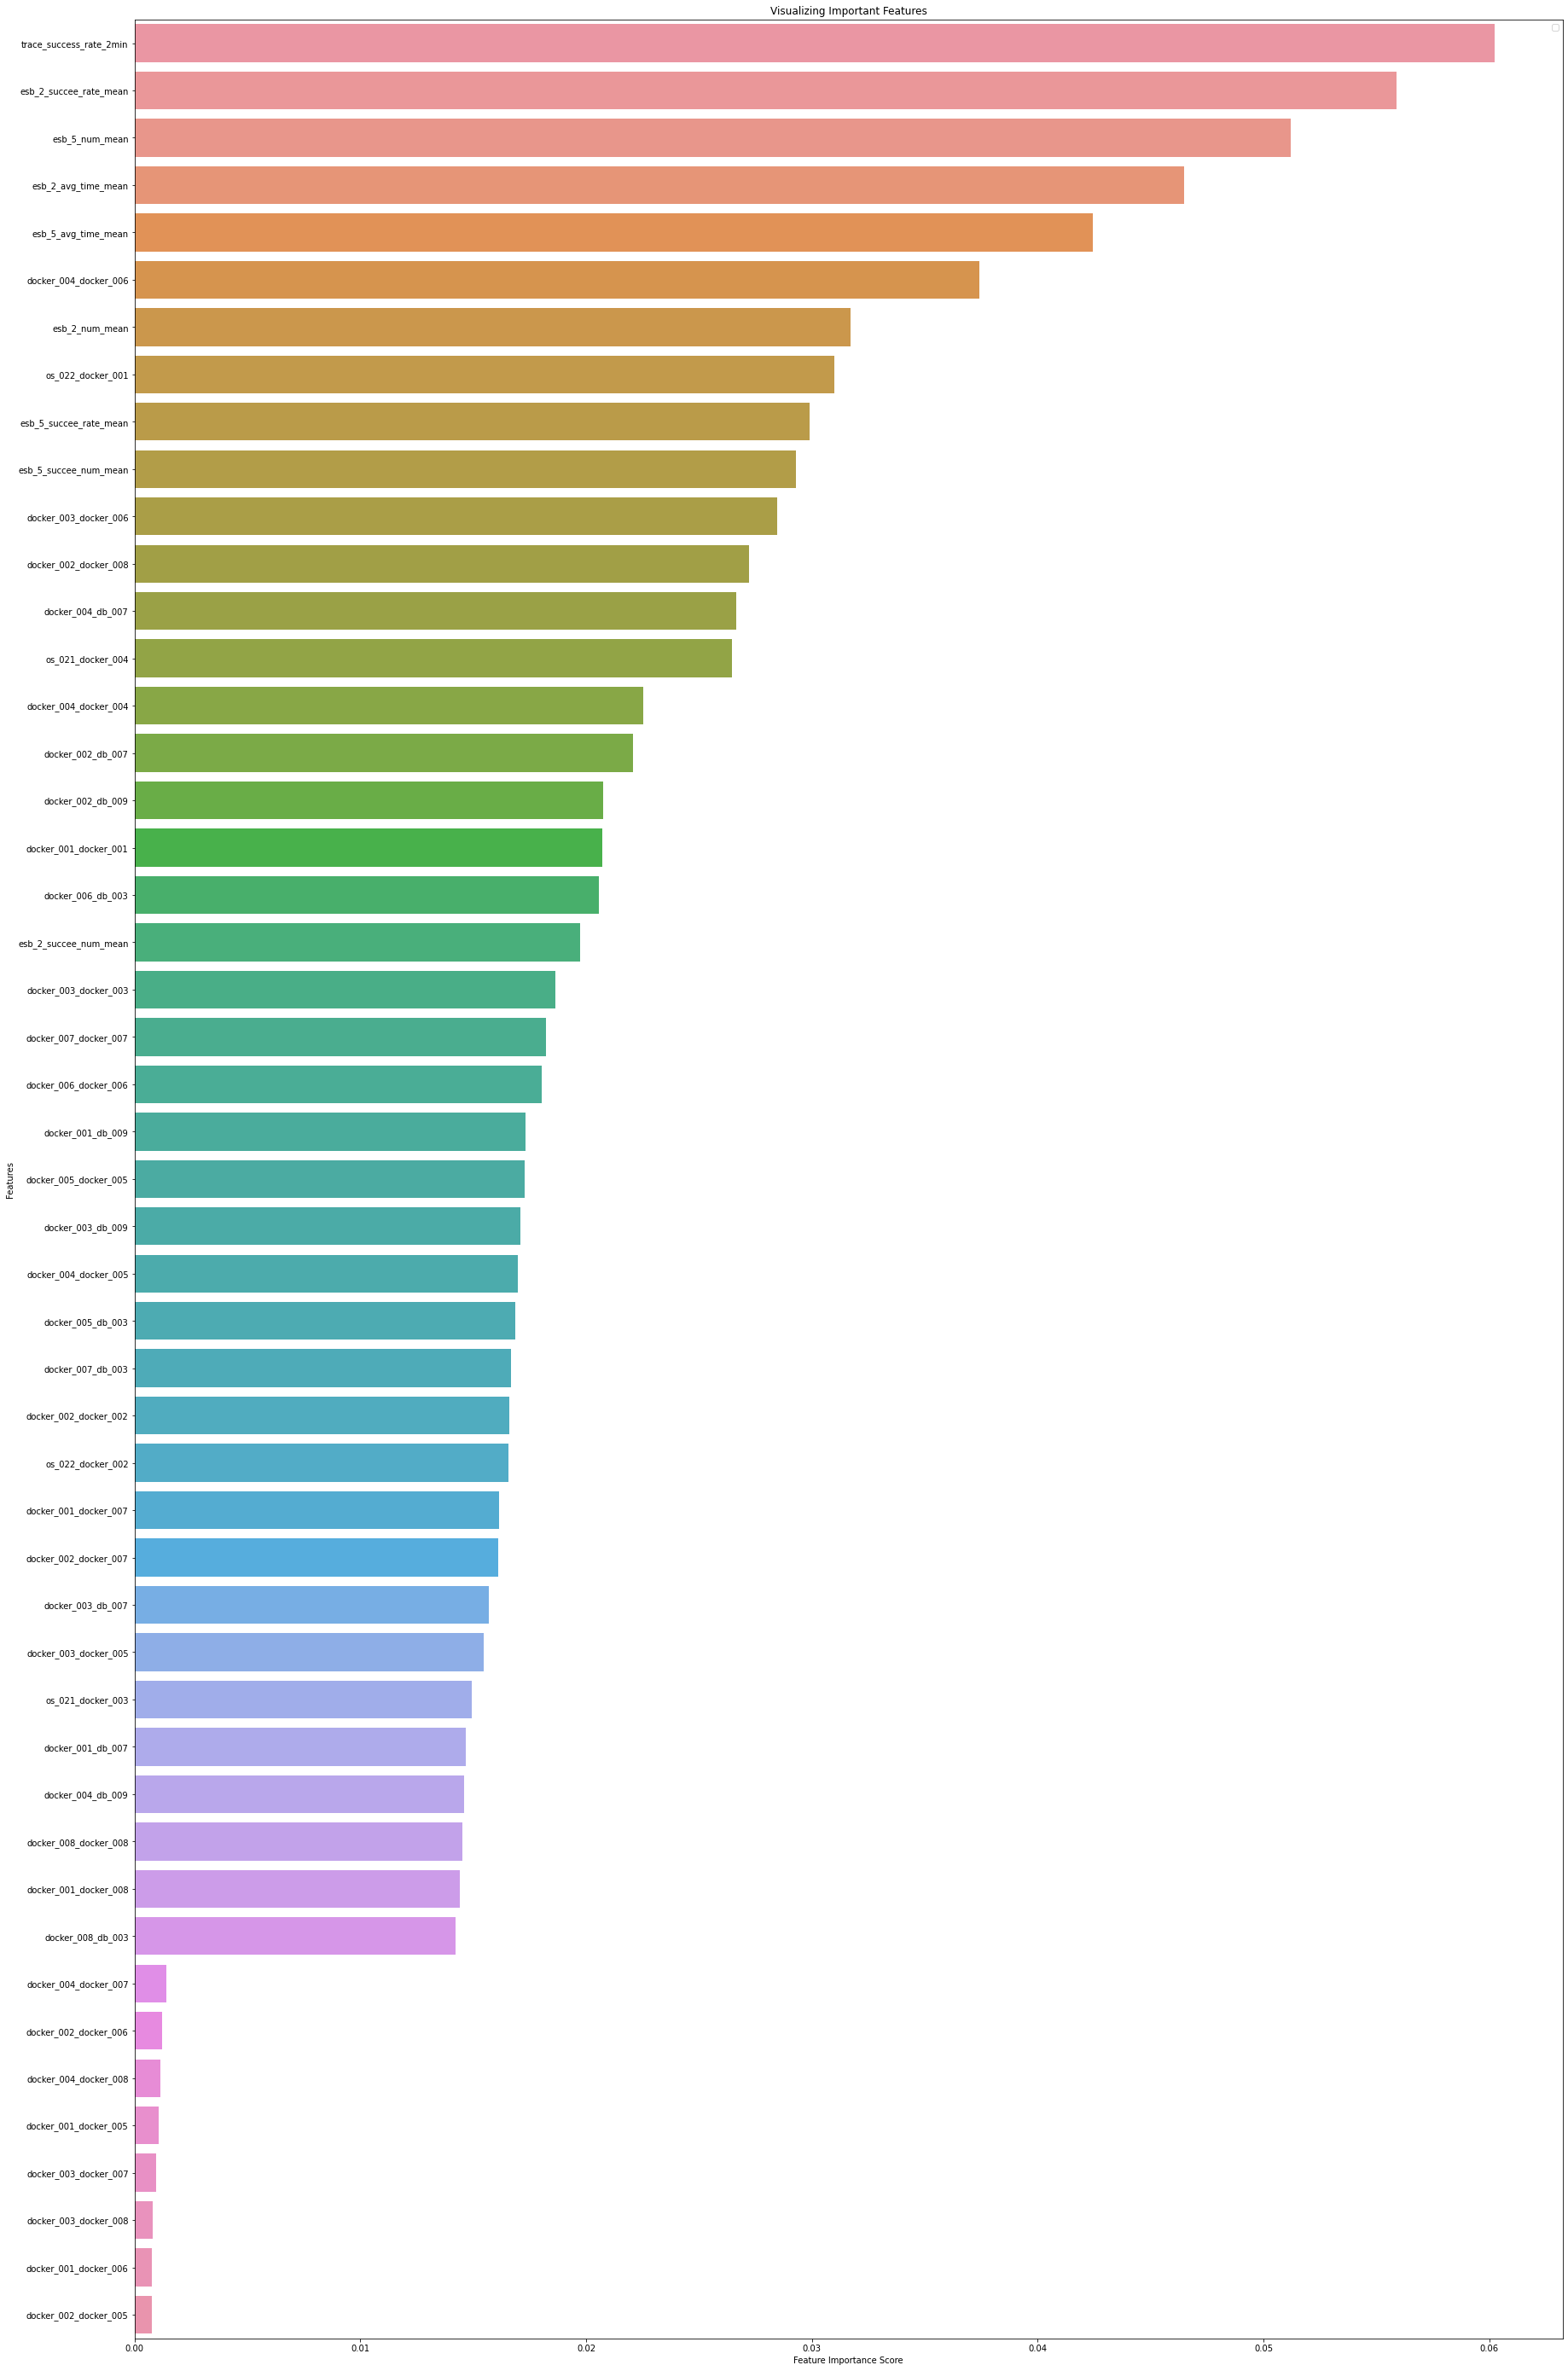

In [84]:
# 特征重要性
importances = model.feature_importances_  #调用Sklearn包得到重要性排序
indices = np.argsort(importances)[::-1]
feature_list = col_names

# 输出排序
print("Feature ranking:")
featurerank=[]
for f in range(X_train.shape[1]):
    featurerank.append(feature_list[indices[f]])
    print("%d. feature %s (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))

#特征重要性可视化
plt.figure(figsize=(30,50))
feature_imp = pd.Series(importances,index=feature_list).sort_values(ascending=False)
sns.barplot(x= feature_imp,y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()